In [1]:
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import glob
import os
import cv2
import argparse
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as kr
from keras import backend as K
from skimage import io, transform, img_as_float 
os.environ['CUDA_VISIBLE_DEVICES'] = '/gpu:0'

image_height = 128
image_width = 128

def train_id_to_path(x):
    return 'SAXSdata1/' + str(x) + ".tif"
    #def test_id_to_path(x):
    #return 'SAXSdata/' + x + ".tif"

def path_to_eagertensor(image_path):
    image = cv2.imread(image_path)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, tf.float32) / 255.0
    #image = tf.image.resize_with_pad(image, image_height, image_width) #optional with padding to retain original dimensions
    image = tf.image.resize(image, (image_height, image_width))
    return image

def int_to_float(image_path):
    image = io.imread(image_path)   #读取图像为整型， [0-255]
    image = img_as_float(image)  #变为浮点型[0-1]。
    image = (image - image.min()) * (1 / (image.max() - image.min()))  #比例缩放的归一化
    image = transform.resize(image, (image_height, image_width))  #图像缩放大小
    return image

def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        ax[0][i].imshow(np.reshape(y_true[i], (128, 128)), aspect='auto',cmap ='gray')
        ax[1][i].imshow(np.reshape(y_pred[i], (128, 128)), aspect='auto',cmap ='gray')
    plt.tight_layout()
    
def getdata():
    cols = ["id", "tem", "strain", "area"]
    df = pd.read_csv("SAXSdata1/saxsdata1.dat", sep=" ", header=None, names=cols)
    df["img_path"] = df["id"].apply(train_id_to_path)
    X = []
    Y = df[["tem","strain"]]
   
    for img in df['img_path']:
        new_img_tensor = int_to_float(img)
        X.append(new_img_tensor)
    
    X = np.array(X)
    print(type(X),X.shape)
    print(type(X),Y.shape)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=42)
    print(type(x_train),x_train.shape)
    print(type(x_test),x_test.shape)
    print(type(y_train),y_train.shape)
    print(type(y_test),y_test.shape)
    return x_train, x_test, y_train, y_test

In [2]:
class VAE():
    def __init__(self):

        self.input_dim = 128*128
        self.latent_dim = 2
        
        self.inputs = kr.Input(shape=(self.input_dim,))
        
        x = kr.layers.Dense(256, activation='relu')(self.inputs)
        x = kr.layers.Dense(128, activation='relu')(x)
        x = kr.layers.Dense(64, activation='relu')(x)

        # shape info needed to build decoder model
        self.shape = x.get_shape().as_list()

        #x = kr.layers.Dense(16, activation='relu')(x)
        self.z_mean = kr.layers.Dense(self.latent_dim)(x)
        self.z_log_var = kr.layers.Dense(self.latent_dim)(x)
        self.z = kr.layers.Lambda(self.sampling, output_shape=(self.latent_dim,))([self.z_mean, self.z_log_var])
        
        # build decoder model
        #latent_inputs = kr.Input(shape=(latent_dim,), name='z_sampling')
        self.dec1 = kr.layers.Dense(64, activation='relu')
        self.dec2 = kr.layers.Dense(128, activation='relu')
        self.dec3 = kr.layers.Dense(256, activation='relu')
        self.dec_out = kr.layers.Dense(self.input_dim, activation='sigmoid')
        
        x = self.dec1(self.z)
        x = self.dec2(x)
        x = self.dec3(x)
        self.outputs = self.dec_out(x)   
        
    # sampling function
    def sampling(self, args):
        z_mean, z_log_var = args
        nd = K.shape(z_mean)[0]
        nc = self.latent_dim
        eps = K.random_normal(shape=(nd, nc), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * eps

    def vae(self):
        return kr.Model(self.inputs, self.outputs)
    
    def encoder(self):
        return kr.Model(self.inputs, self.z_mean)
    
    def decoder(self):
        z = kr.Input(shape=(self.latent_dim,))
        x = self.dec1(z)
        x = self.dec2(x)
        x = self.dec3(x)
        x_out = self.dec_out(x)  
        return kr.Model(z, x_out)

    def loss(self):
        mse = kr.metrics.mean_absolute_error(self.inputs, self.outputs)
        xent_loss = self.input_dim * mse
        kl = 1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var)
        kl_loss = - 0.5 * K.sum(kl, axis=-1)
        vae_loss = K.mean(xent_loss + kl_loss)
        return vae_loss

In [3]:
x_train, x_test, y_train, y_test = getdata()
n, h, w = x_train.shape
n1, h1, w1 = x_test.shape
X_train = x_train.reshape(n, -1)
X_test = x_test.reshape(n1, -1)
min_max_scaler = MinMaxScaler()
#X_train = min_max_scaler.fit_transform(X_train)
#X_test = min_max_scaler.fit_transform(X_test)
print(type(X_train),X_train.shape)
print(type(X_test),X_test.shape)

<class 'numpy.ndarray'> (5046, 128, 128)
<class 'numpy.ndarray'> (5046, 2)
<class 'numpy.ndarray'> (4793, 128, 128)
<class 'numpy.ndarray'> (253, 128, 128)
<class 'pandas.core.frame.DataFrame'> (4793, 2)
<class 'pandas.core.frame.DataFrame'> (253, 2)
<class 'numpy.ndarray'> (4793, 16384)
<class 'numpy.ndarray'> (253, 16384)


In [ ]:
seed = 0
batch_size = 64
epochs = 500

np.random.seed(seed)
vae = VAE()
model = vae.vae()
model.summary()
model.add_loss(vae.loss())

np.random.seed(seed)
model.compile(optimizer='adam', loss=None)
history = model.fit(X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, None))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("kl-mae loss")
plt.legend()

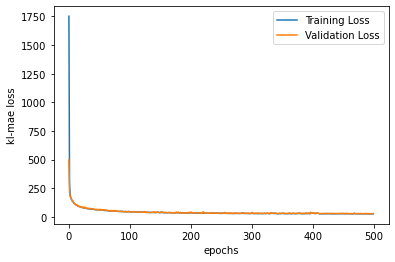

In [5]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("kl-mae loss")
plt.legend()

<class 'numpy.ndarray'> (121, 2)


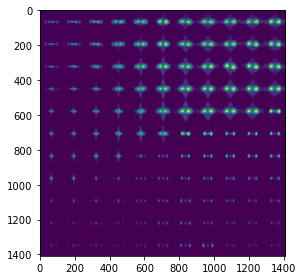

array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,
        1.25,  1.5 ])

In [18]:
# decode images from 2-dim latent z
ndiv = 11 # number of images for axis
dec = vae.decoder()
gx = np.linspace(-1, 1.5, ndiv)
gy = np.linspace(1, -1.5, ndiv)
gxx, gyy = np.meshgrid(gx, gy)
z = np.append(gxx.reshape(-1,1), gyy.reshape(-1,1), axis=1)
print(type(z),z.shape)
x = dec.predict(z)
dst = x.reshape(ndiv,ndiv,128,128)
dst = dst.transpose(0,2,1,3)
dst = dst.reshape(ndiv*128, ndiv*128)

# plot images
plt.imshow(dst)
plt.tight_layout();plt.show()
gx

In [7]:
from matplotlib import cm
from skimage import io as skio
out = (cm.inferno(dst)[:,:,:3]*255).astype(np.uint8)
skio.imsave('vae_out_%03d.png' % 11, out)

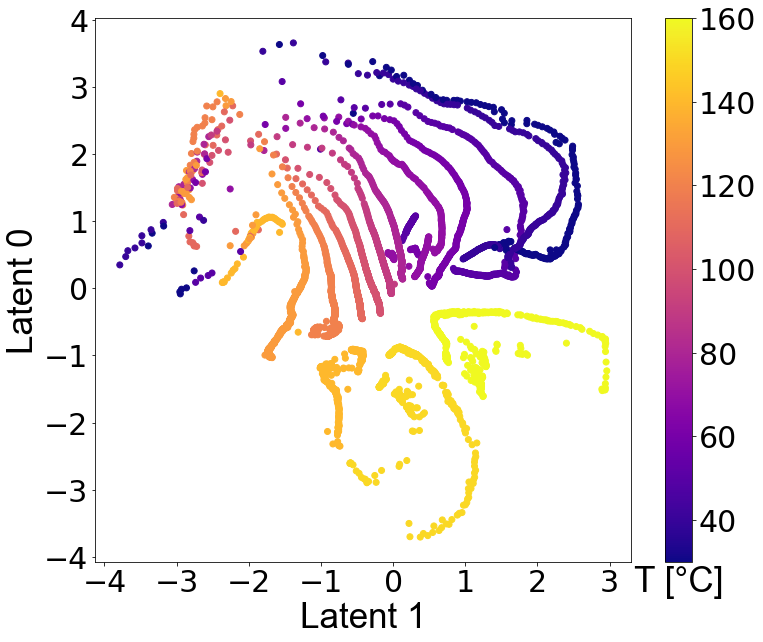

In [6]:
enc = vae.encoder()
def plot_digits1(X, y, encoder):
    # display a 2D plot of the digit classes in the latent space
    z_mean = encoder.predict(X)
    
    #x1 = np.array([[40,130]])
    #x2 = np.array([[40,130]])
    #latent1 = dnn.predict(x1)
    #latent2 = dnn.predict(x2)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y, cmap = 'plasma')
    #my_x_ticks = np.arange(-2,3,0.3)
    #my_y_ticks = np.arange(-2,3,0.3)
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    #plt.xticks(my_x_ticks)
    #plt.yticks(my_y_ticks)
    cb=plt.colorbar()
    cb.ax.tick_params(labelsize=30)
    cb.ax.set_xlabel('T [°C]', size=35,fontproperties="Arial")
    plt.xlabel("Latent 1",fontsize = 35,fontproperties="Arial")
    plt.ylabel("Latent 0",fontsize = 35,fontproperties="Arial")
    #plt.scatter(latent1[0, 0], latent1[0, 1], s=400,c='none', marker='o',linewidths = 3, edgecolors='r')
    #plt.scatter(latent2[0, 0], latent2[0, 1], s=300,c='g', marker='*',linewidths = 2, edgecolors=None)
    #plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图2\1")
    plt.show()
def plot_digits2(X, y, encoder):
    # display a 2D plot of the digit classes in the latent space
    z_mean = encoder.predict(X)
    
    #x1 = np.array([[40,130]])
    #latent1 = dnn.predict(x1)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y, cmap = 'plasma')
    #my_x_ticks = np.arange(-2,3,0.3)
    #my_y_ticks = np.arange(-2,3,0.3)
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    #plt.xticks(my_x_ticks)
    #plt.yticks(my_y_ticks)
    cb=plt.colorbar()
    cb.ax.tick_params(labelsize=30)
    cb.ax.set_xlabel('ε [%]', size=35,fontproperties="Arial")
    plt.xlabel("Latent 1",fontsize = 35,fontproperties="Arial")
    plt.ylabel("Latent 0",fontsize = 35,fontproperties="Arial")
    #plt.scatter(latent1[0, 0], latent1[0, 1], s=400,c='none', marker='o',linewidths = 3, edgecolors='r')
    #plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图2\2")
    plt.show()
plot_digits1(X_train, y_train["tem"], enc)  # y for label coloring 

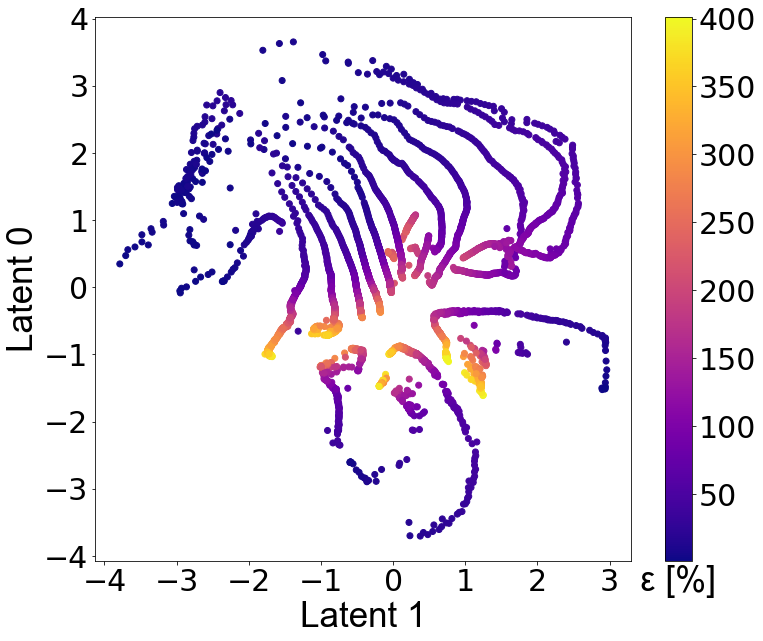

In [7]:
plot_digits2(X_train, y_train["strain"], enc)  # y for label coloring 

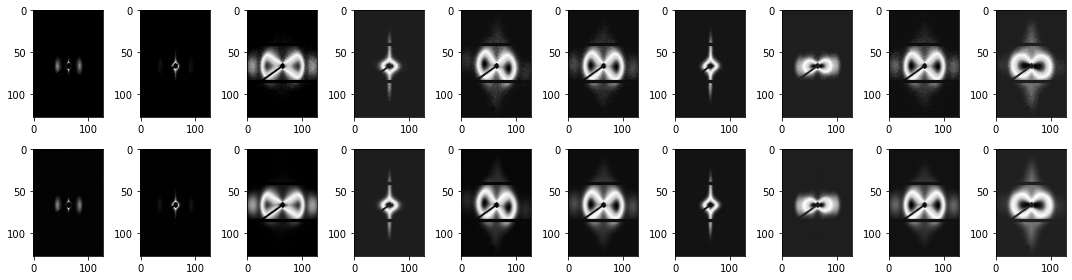

In [68]:
y_true = X_test[0:10]
y_pred = model.predict(y_true)
plot_predictions(y_true, y_pred)

In [8]:
z_mean = enc.predict(X_train)
y1 = y_train[["tem","strain"]]
print(type(y1),y1.shape)
print(type(z_mean),z_mean.shape)
#y2 = y_train["strain"]
y1 = np.array(y1)
x = z_mean
print(type(x),x.shape)

<class 'pandas.core.frame.DataFrame'> (4793, 2)
<class 'numpy.ndarray'> (4793, 2)
<class 'numpy.ndarray'> (4793, 2)


In [9]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(y1, x, test_size=0.05)
print(type(x_train1),x_train1.shape)
print(type(y_train1),y_train1.shape)

<class 'numpy.ndarray'> (4553, 2)
<class 'numpy.ndarray'> (4553, 2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130       
Total params: 8,770
Trainable params: 8,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
41/41 [==============================] - 0s 5ms/step - loss: 104.3399 - mae: 5.8942 - mse: 104.3399 - val_loss: 3.3148 - val_mae: 1.3832 - val_mse: 3.3148
Epoch 2/1000
41/41 [==============================] - 0s 3ms/step - loss: 1.8868 - mae: 1.0248 - mse: 1.8868 - val_loss: 1.2639 - val_mae: 0.8434 - val_mse: 1.2639
Epoch 3/1000
41/41 [==============================] 

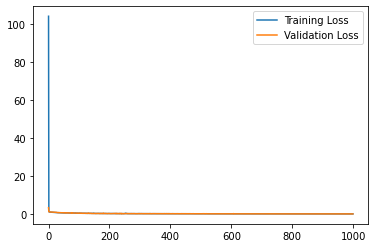

In [10]:
dnn = kr.Sequential([
    kr.layers.Dense(128, activation='relu', input_shape=(2,)),
    kr.layers.Dense(64, activation='relu'),
#    kr.layers.Dense(32, activation='relu'),
    kr.layers.Dense(2, activation='linear')
])
dnn.summary()
dnn.compile(optimizer='adam',
              loss='mse',
              metrics=['mae', 'mse'])
history = dnn.fit(x_train1, y_train1, batch_size=100, epochs=1000, validation_split = 0.1, verbose=1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

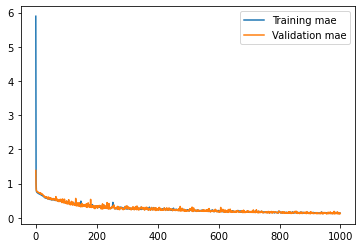

In [11]:
plt.plot(history.history['mae'], label="Training mae")
plt.plot(history.history["val_mae"], label="Validation mae")
plt.legend()

<class 'numpy.ndarray'> (240, 2)
<class 'numpy.ndarray'> (240, 2)


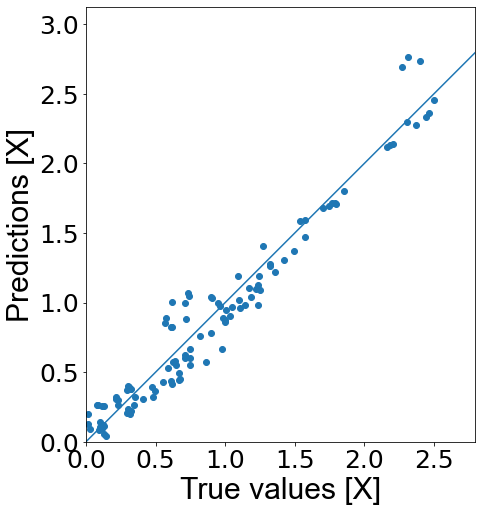

In [12]:
print(type(x_test1),x_test1.shape)
print(type(y_test1),y_test1.shape)
test_predictions = dnn.predict(x_test1)
plt.figure(figsize=(8, 8))
plt.scatter(y_test1[:,0], test_predictions[:,0])
plt.xlabel('True values [X]',fontsize = 30,fontproperties="Arial")
plt.ylabel('Predictions [X]',fontsize = 30,fontproperties="Arial")
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
#plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图\6\1")

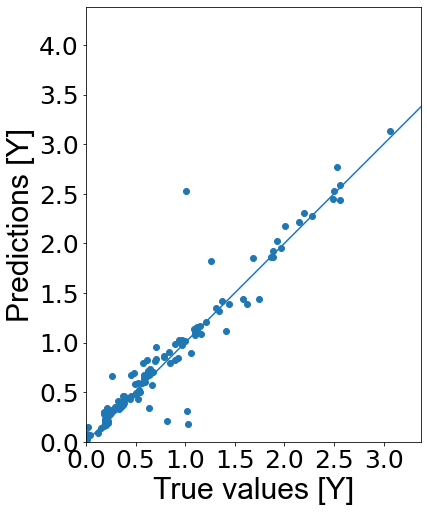

In [13]:
plt.figure(figsize=(8.5, 8))
plt.scatter(y_test1[:,1], test_predictions[:,1])
plt.xlabel('True values [Y]',fontsize = 30,fontproperties="Arial")
plt.ylabel('Predictions [Y]',fontsize = 30,fontproperties="Arial")
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
#plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图\6\2")

(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

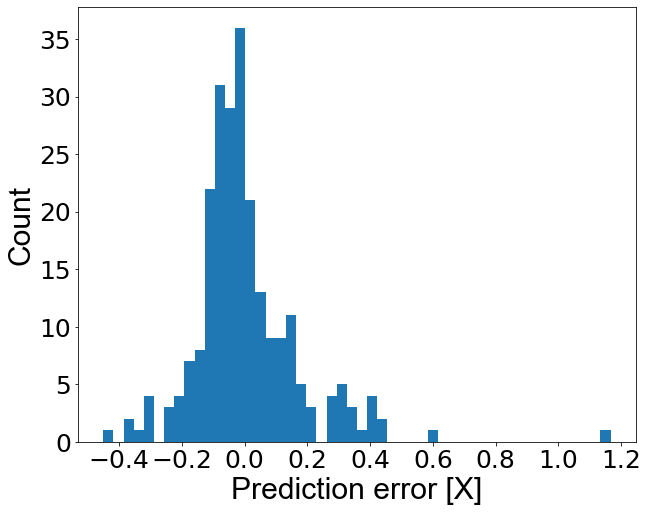

In [14]:
plt.figure(figsize=(10, 8))
error = test_predictions[:,0] - y_test1[:,0]
plt.hist(error, bins = 50)
plt.xlabel("Prediction error [X]",fontsize = 30,fontproperties="Arial")
_ = plt.ylabel("Count",fontsize = 30,fontproperties="Arial")
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
#plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图\6\3")

(array([ 0., 10., 20., 30., 40., 50., 60., 70., 80.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

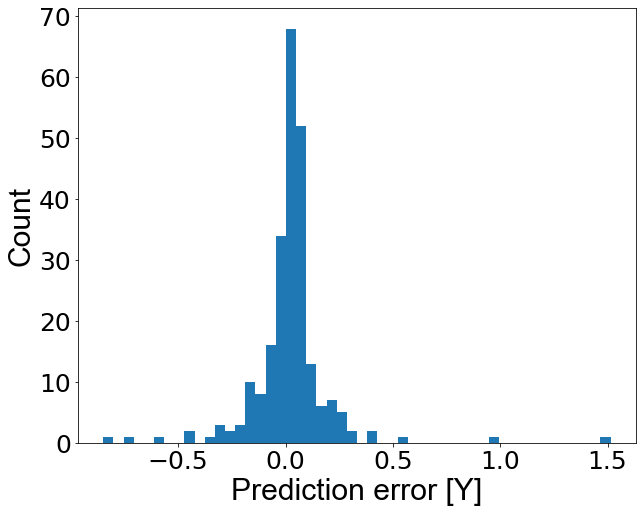

In [15]:
plt.figure(figsize=(10, 8))
error = test_predictions[:,1] - y_test1[:,1]
plt.hist(error, bins = 50)
plt.xlabel("Prediction error [Y]",fontsize = 30,fontproperties="Arial")
_ = plt.ylabel("Count",fontsize = 30,fontproperties="Arial")
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
#plt.savefig(r"C:\Users\zch\Desktop\7.4\数据整理\文章用图\6\4")

In [54]:
print(x_test1[0])
print(y_test1[0])
print(test_predictions[0])

[160.         253.47764228]
[-0.7602957  1.5140457]
[-0.7536542  1.4721508]


<class 'numpy.ndarray'> (600, 2)
<class 'numpy.ndarray'> (600, 2)


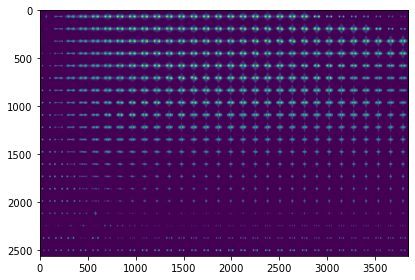

<class 'numpy.ndarray'> (20, 30)
<class 'numpy.ndarray'> (20, 30)
<class 'numpy.ndarray'> (600, 2)


array([[ 20.        ,   0.        ],
       [ 20.        ,   8.62068966],
       [ 20.        ,  17.24137931],
       ...,
       [160.        , 232.75862069],
       [160.        , 241.37931034],
       [160.        , 250.        ]])

In [21]:
from matplotlib import cm
from skimage import io as skio
# decode images from 2-dim latent z
ndivx = 30 # number of images for axis
ndivy = 20
gx = np.linspace(0, 250, ndivx)
gy = np.linspace(20, 160, ndivy)
gxx, gyy = np.meshgrid(gx, gy)
z = np.append(gyy.reshape(-1,1), gxx.reshape(-1,1), axis=1)
print(type(z),z.shape)
letent = dnn.predict(z)
print(type(letent),letent.shape)
x = dec.predict(letent)
dst = x.reshape(ndivy,ndivx,128,128)
dst = dst.transpose(0,2,1,3)
dst = dst.reshape(ndivy*128, ndivx*128)

# plot images
plt.imshow(dst)
plt.tight_layout();plt.show()
out = (cm.inferno(dst)[:,:,:3]*255).astype(np.uint8)
skio.imsave('vae_pic_%03d.png' % 1, out)
print(type(gxx),gxx.shape)
print(type(gyy),gyy.shape)
print(type(z),z.shape)
z